## Exercise: using `julia_call` package in R

If you are an extensive R user and are not ready to fully switch to Julia, but still want to experience some features in Julia, such as using some Julia packages for your data analysis, this exercise would be particularly of your interests. 

For this exercise, we would use the Julia package `MatrixLM.jl`, a fast application of fitting multivariate linear models in Julia. We will fit the model:

$$Y = XBZ^T+E
$$

where 

- $Y$ is the multivariate response of dimension $n \times m$
- $X$ is the design matrix of row covariates of dimension $n \times p$
- $Z$ is the design matrix of column covariates of dimension $m \times q$
- $B$ is the matrix of interative effects of row and column covariates; it has dimension $p \times q$
- $E$ is the $n \times m$ matrix of normal noises.


We will be simulating data using R code, and use `MatrixLM.jl`

The goal of this exercise is mainly to familiarize you with the `R/julia_call` functionalities, by which you can easily utilize some additional features in Julia running Julia packages in the backend, while still staying in the R interface.

**Load R libraries:**

In [42]:
library(dplyr);

# install.packages(JuliaCall)
library(JuliaCall)
# julia_setup(installJulia = TRUE) # for the first time, run this to initialize JuliaCall

#### Ex.1: Simulate data in R

Set the random seed to be 1. Then, simulate the data as the following:

- n = 100, m = 250
- The number of row covariates, p = 5
- The number of column covariates, q = 5
- Simulate X, Z, B as matrices of uniformly distributed numbers in [0, 1], of the corresponding sizes 
- Simulate random normal errors E with standard deviation $\sigma = 0.1$
- Simulate Y by the model $Y = XBZ^T+E$

##### Ex.1 - solution:

In [43]:
# Sizes of row covariates
n <- 100
p <- 5

# Sizes of column covariates
m <- 250
q <- 5

In [44]:
# set random seed
set.seed(1)

X = matrix(runif(n*p), nrow = n) # design matrix of row covariates X
Z = matrix(runif(m*q), nrow = m) # design matrix of column covariates X

B = matrix(runif(p*q, -5, 5), nrow = p) # true coefficient matrix B
E = matrix(rnorm(n*m, sd = 0.1), nrow = n) # standard normal errors E
Y = X %*% B %*% t(Z) + E # simulating multivariate response matrix Y

#### Ex.2: Load data into Julia 
(using `julia_assign()`)

##### Ex.2 - solution:

In [45]:
# Assign variables to the Julia environment...
julia_assign("X", X);
julia_assign("B", B);
julia_assign("Z", Z);
julia_assign("Y", Y)

Then, for example, if you run

In [46]:
julia_eval("X[1:6, :]") # check the first 6 rows of X in Julia

0.2655087,0.6547239,0.2675082,0.67371223,0.6588776
0.3721239,0.3531973,0.2186453,0.09485786,0.1850700
0.5728534,0.2702601,0.5167968,0.49259612,0.9543781
0.9082078,0.9926841,0.2689506,0.46155184,0.8978485
0.2016819,0.6334933,0.1811683,0.37521653,0.9436971
0.8983897,0.2132081,0.5185761,0.99109922,0.7236908


and

In [47]:
head(X) # check the first 6 rows of X in R

0.2655087,0.6547239,0.2675082,0.67371223,0.6588776
0.3721239,0.3531973,0.2186453,0.09485786,0.1850700
0.5728534,0.2702601,0.5167968,0.49259612,0.9543781
0.9082078,0.9926841,0.2689506,0.46155184,0.8978485
0.2016819,0.6334933,0.1811683,0.37521653,0.9436971
0.8983897,0.2132081,0.5185761,0.99109922,0.7236908


you shall see that the X matrix has been loaded into Julia.

#### Ex.3: Check all simulated data has been loaded into Julia
(using `julia_exists`)

##### Ex.3 - solution:

In [48]:
sapply(c("X", "B", "Z", "Y"), julia_exists)

X    B    Z    Y 
TRUE TRUE TRUE TRUE

you should be able to confirm that the data has been loaded into Julia.

#### Ex.4 - Load package in Julia
(using `julia_library()`)

##### Ex.4 - solution:

In [49]:
julia_library("MatrixLM")

or, more intuitively, use `julia_command()` or `julia_eval()`

In [50]:
julia_eval("using MatrixLM") # will print NULL because nothing is returned from this command

NULL

In [51]:
julia_command("using MatrixLM");

#### Ex.5: Extract the output from Julia into R 

First, evaluate the Matrix Linear Model by running the following Julia command (you can copy and paste each line to a line executing `julia_command()`)

```julia
dat = RawData(Response(Y), Predictors(X, Z));
est = mlm(dat; hasXIntercept = false, hasZIntercept = false);

```

Next, after the package finished the task, extract the output estimated $B$ and assign it to a variable in R environment.

**Which one should you use? `julia_command()` or `julia_eval()`? Test it out!**

```julia
coef(est)
```

##### Ex.5 - solution:

In [52]:
# Construct a RawData object
julia_command("dat = RawData(Response(Y), Predictors(X, Z));")
julia_command("est = mlm(dat; hasXIntercept = false, hasZIntercept = false);")

We shall learn that `julia_command()` will not return the output but only display the result as in the Julia console.

In [53]:
B_hat_nothing <- julia_command("coef(est)")

5×5 Matrix{Float64}:
 0.749082 -4.63939 -3.25801 0.875111 4.59497
 0.964557 1.25309 -0.0663613 0.726904 -1.18719
 0.68714 -0.656523 2.36629 1.55231 -3.29546
 -2.81598 -1.43399 0.106681 3.64763 -2.68305
 3.20676 2.73621 -0.248831 -1.02727 4.498

In [54]:
class(B_hat_nothing)

[1] "NULL"

We shall use `julia_eval()` to execute the command and assign the output returned to a variable to be used in R later.

In [55]:
B_hat <- julia_eval("coef(est)") # Get the coefficients of the model

In [56]:
class(B_hat)

[1] "matrix" "array"

Check that you shall get the similar results as the following:

In [57]:
B_hat |> round(digits = 2) # estimated coefficients by MatrixLM

0.75,-4.64,-3.26,0.88,4.59
0.96,1.25,-0.07,0.73,-1.19
0.69,-0.66,2.37,1.55,-3.30
-2.82,-1.43,0.11,3.65,-2.68
3.21,2.74,-0.25,-1.03,4.50


In [58]:
B |> round(digits = 2) # true coefficients

0.74,-4.63,-3.27,0.88,4.60
0.97,1.26,-0.07,0.73,-1.19
0.70,-0.67,2.37,1.55,-3.30
-2.82,-1.43,0.11,3.65,-2.68
3.20,2.74,-0.25,-1.03,4.50


##### Appendix: a simple example of downstream analysis in R!

Packages in Julia, such as `MatrixLM.jl` (feel free to explore [here](https://github.com/senresearch/MatrixLM.jl)), provides many useful features. With `JuliaCall`, R users can easily use these features in Julia for computational tasks in the backend, and extract the results for downstream analyses in R.

For example, with `MatrixLM.jl`, we can get residuals from the fitted model 

In [59]:
resids <- julia_eval("resids = resid(est)");

then visualize the result (with any graphing tools of your choice) using the powerful visualization features in R.

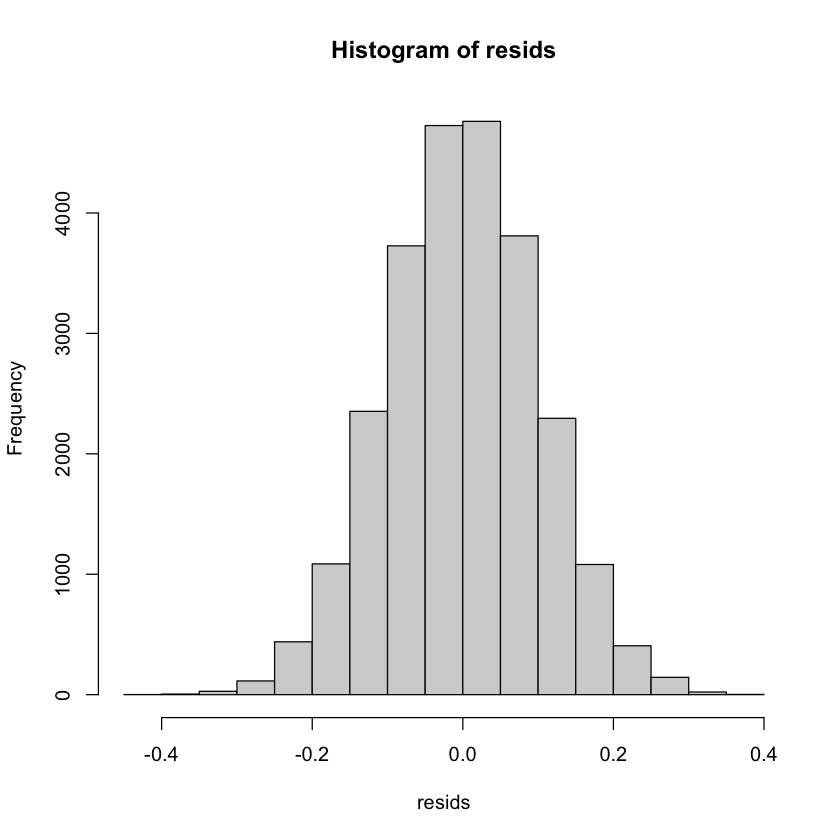

In [60]:
hist(resids) # here we just used Base.R

Hope you enjoyed the workshop and hope you will explore Julia more yourself in the future!